In [2]:
import pandas as pd
import re

In [4]:
lmo_detailed_df = pd.read_excel('/Users/rohitroy/Downloads/Data Scientist Program/A_NEWLY_HIRED_DATA_ANALYST/LMO_Detailed_Industries_by_NAICS.xlsx')
data_output_df  = pd.read_excel('/Users/rohitroy/Downloads/Data Scientist Program/A_NEWLY_HIRED_DATA_ANALYST/Data_Output_Template.xlsx')

merged_df = data_output_df.merge(lmo_detailed_df, on="LMO_Detailed_Industry")
merged_df.NAICS = merged_df.NAICS.astype('str')

In [9]:
print_ = True
rtra_filename = ''
for index, row in merged_df.iterrows():
    naics = row["NAICS"]
    naics_codes = list(map(str.strip, re.split(',|&', naics)))
    year = row['SYEAR']
    month = row['SMTH']
    n_digits = len(naics_codes[0])
    
    if 1997 <= int(year) <= 1999:
        year_range = '97_99'
    elif 2000 <= int(year) <= 2005:
        year_range = '00_05'
    elif 2006 <= int(year) <= 2010:
        year_range = '06_10'
    elif 2011 <= int(year) <= 2015:
        year_range = '11_15'
    elif 2016 <= int(year) <= 2020:
        year_range = '16_20'
    
    # files should be read only when the year cannot be found in the currently opened RTRA file, the following code ensures that
    if index == 0:
        year_range_old, month_old, n_digits_old = year_range, month, n_digits
        
    if index == 0 or (year_range != year_range_old or n_digits != n_digits_old):
        rtra_filename = f"/Users/rohitroy/Downloads/Data Scientist Program/A_NEWLY_HIRED_DATA_ANALYST/RTRA_Employ_{n_digits}NAICS_{year_range}.csv"
        rtra_df_ori = pd.read_csv(rtra_filename)
        
    # filter out year and months we are not interested in
    rtra_df = rtra_df_ori.loc[(rtra_df_ori['SYEAR'] == year) & (rtra_df_ori['SMTH'] == month)]
    
    # RTRA file with four digit has different value structure for the NAICS column, it is just the value
    if n_digits != 4:
        rtra_df['naics_code'] = rtra_df.NAICS.str.split(r'\[|\]', expand=True)[1].astype("string")
    else:
        rtra_df['naics_code'] = rtra_df['NAICS'].astype("string")

    year_range_old, n_digits_old = year_range, n_digits
    
    total_employment = 0
    for this_naics_code in naics_codes:
        # get the value from RTRA file using year, month and naics_code
        if rtra_df[ (rtra_df['naics_code'] == this_naics_code) ].shape[0] > 0:
            industry_employment_by_year_month = rtra_df[ (rtra_df['naics_code'] == this_naics_code) ].iloc[0]['_EMPLOYMENT_']
        # print(f"industry_employment by_{year}_{month}_code_{this_naics_code}: {industry_employment_by_year_month}")
        total_employment += industry_employment_by_year_month
    # set the total employment count value back in the output template
    merged_df.loc[(merged_df['SYEAR'] == year) & (merged_df['SMTH'] == month) & (merged_df['LMO_Detailed_Industry'] == row['LMO_Detailed_Industry']), 'Employment'] = total_employment


<ipython-input-9-2a8436e29853>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rtra_df['naics_code'] = rtra_df.NAICS.str.split(r'\[|\]', expand=True)[1].astype("string")
<ipython-input-9-2a8436e29853>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rtra_df['naics_code'] = rtra_df.NAICS.str.split(r'\[|\]', expand=True)[1].astype("string")
<ipython-input-9-2a8436e29853>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [10]:
merged_df.head()

SYEAR  SMTH   LMO_Detailed_Industry  Employment NAICS
0   1997     1  Accommodation services     24000.0   721
1   1997     2  Accommodation services     24250.0   721
2   1997     3  Accommodation services     27750.0   721
3   1997     4  Accommodation services     29750.0   721
4   1997     5  Accommodation services     34000.0   721

In [11]:
output_df = merged_df.drop('NAICS', axis=1)
output_df.sort_values(by=['SYEAR', 'SMTH', 'LMO_Detailed_Industry'], inplace=True)
output_df = output_df.reset_index(drop=True)
output_df.to_excel('output.xlsx', index=False)

<AxesSubplot:xlabel='SYEAR'>

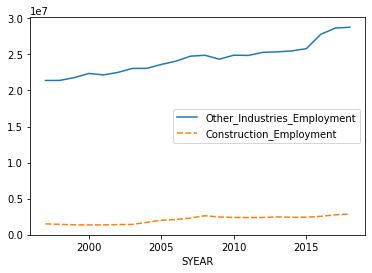

In [12]:
# !pip install seaborn

import seaborn as sns

output_df_cpy = output_df.copy()

other_industries = output_df_cpy[output_df_cpy["LMO_Detailed_Industry"] != 'Construction']
other_industries_summary = other_industries.groupby(["SYEAR"]).sum().drop('SMTH', axis=1)

construction_industry = output_df_cpy[output_df_cpy["LMO_Detailed_Industry"] == 'Construction']
construction_industry_summary = construction_industry.groupby(["SYEAR"]).sum().drop('SMTH', axis=1)

# idx = pd.IndexSlice
# construction = construction_industry_summary.loc[idx[:, ["Construction"]], : ]
construction_industry.rename(columns={'Employment':'Construction_Emp'}, inplace=True)
other_industries.rename(columns={'Employment':'Other_Industries_Emp'}, inplace=True)

combined_summaries = other_industries_summary.merge(construction_industry_summary, left_index=True, right_index=True)
# print(combined_summaries)
sns.lineplot(data=combined_summaries)


In [13]:
idx = output_df_cpy.groupby('SYEAR')['Employment'].idxmax()
print(output_df_cpy.loc[idx].head(22))

       SYEAR  SMTH                              LMO_Detailed_Industry  \
387     1997     7  Other retail trade (excluding cars and persona...   
1390    1998    12  Other retail trade (excluding cars and persona...   
1567    1999     3  Other retail trade (excluding cars and persona...   
2511    2000     7  Other retail trade (excluding cars and persona...   
3455    2001    11  Other retail trade (excluding cars and persona...   
4222    2002    12  Other retail trade (excluding cars and persona...   
4930    2003    12  Other retail trade (excluding cars and persona...   
4989    2004     1  Other retail trade (excluding cars and persona...   
6346    2005    12  Other retail trade (excluding cars and persona...   
6523    2006     3  Other retail trade (excluding cars and persona...   
7703    2007    11  Other retail trade (excluding cars and persona...   
8116    2008     6  Other retail trade (excluding cars and persona...   
9178    2009    12  Other retail trade (excluding c

<AxesSubplot:xlabel='SYEAR'>

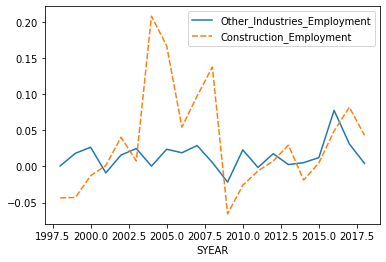

In [14]:
sns.lineplot(data=combined_summaries.pct_change())


<AxesSubplot:>

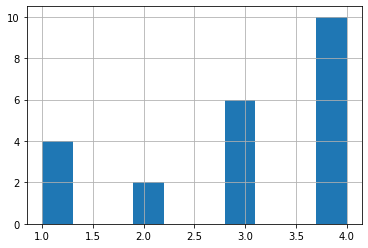

In [15]:
def get_quarter(m):
    return (m-1)//3 + 1

idx = output_df_cpy.groupby('SYEAR')['Employment'].idxmax()
result = output_df_cpy.loc[idx]

result['Qtr'] = result['SMTH'].map(lambda x: get_quarter(x))
result['Qtr'].hist()

<AxesSubplot:xlabel='SYEAR', ylabel='Employment'>

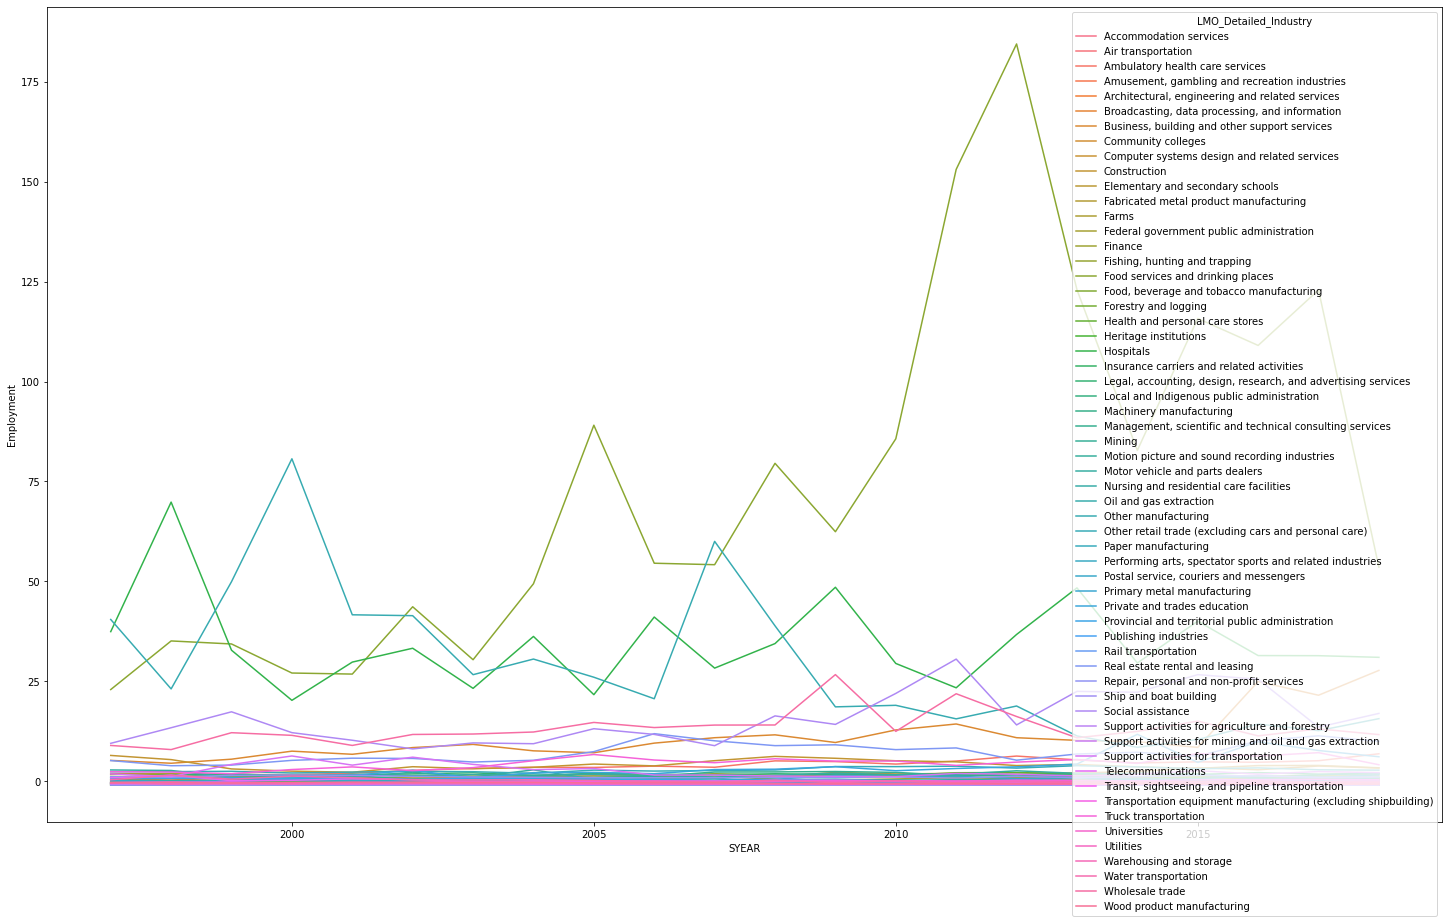

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,15))

sns.lineplot(x="SYEAR", y=output_df_cpy['Employment'].pct_change(), hue="LMO_Detailed_Industry", data=output_df_cpy, ci=None)